In [11]:
import os
import re
import json
from urllib.parse import urlparse
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from collections import Counter, defaultdict
from datetime import datetime
import logging
import statistics


In [12]:
# Step 1: Locate and load config.json from one level up
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
config_path = os.path.normpath(os.path.join(parent_dir, 'config.json'))

with open(config_path, 'r', encoding='utf-8') as f:
    config = json.load(f)

# Step 2: Build absolute path prefix based on where config.json was loaded from
config_dir = os.path.dirname(config_path)

In [13]:
def collect_and_analyze_ttps(primary_folder, secondary_folder):
    """
    Collect and analyze TTPs from two folders. 
    
    Performs file-wise TTP counting and statistical analysis on the number of unique TTPs per file.

    Parameters
    ----------
    primary_folder : str
        The path of the first folder.
    secondary_folder : str
        The path of the second folder.

    Returns
    -------
    dict
        A dictionary containing:
        - cumulative_unique_ttps: Number of unique TTPs across all files.
        - average_ttps: Average number of unique TTPs per file.
        - median_ttps: Median number of unique TTPs per file.
        - mode_ttps: Mode of unique TTP counts per file.
        - file_ttp_counts: List of unique TTP counts per file.
        - file_paths: List of file paths corresponding to the TTP counts.
    """
    # Regex to capture full TTP IDs (e.g., T1003, T1018, T1037)
    ttp_pattern = re.compile(r'\bT\d{4}(?:\.\d+)?\b')

    # Set to store cumulative unique TTPs across all files
    cumulative_unique_ttps = set()

    # Lists to store the count of TTPs and file paths
    file_ttp_counts = []
    file_paths = []

    # List of folder paths to iterate over
    folder_paths = [primary_folder, secondary_folder]

    # Loop through both folders
    for folder_path in folder_paths:
        # Loop through files in the specified folder
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            
            # Skip if it's not a file
            if not os.path.isfile(file_path):
                continue

            # Set to store unique TTPs in the current file
            unique_ttps_in_file = set()

            # Open the file and check each line for TTP patterns
            with open(file_path, 'r') as file:
                for line in file:
                    # Find all TTP IDs in the line and add them to the file's set
                    matches = ttp_pattern.findall(line)
                    unique_ttps_in_file.update(matches)

            # Add the unique TTPs from the current file to the cumulative set
            cumulative_unique_ttps.update(unique_ttps_in_file)

            # Store the count of TTPs in the current file and its path
            file_ttp_counts.append(len(unique_ttps_in_file))
            file_paths.append(file_path)

    # Calculate the statistics
    num_cumulative_unique_ttps = len(cumulative_unique_ttps)
    average_ttps = statistics.mean(file_ttp_counts) if file_ttp_counts else 0
    median_ttps = statistics.median(file_ttp_counts) if file_ttp_counts else 0
    mode_ttps = statistics.mode(file_ttp_counts) if file_ttp_counts else None

    # Filter the results to get files with exactly 1 unique TTP
    files_with_one_ttp = {file_paths[i]: count for i, count in enumerate(file_ttp_counts) if count == 1}
    
    print(f"Number of files with exactly 1 unique TTP: {len(files_with_one_ttp)}")

    return {
        "cumulative_unique_ttps": num_cumulative_unique_ttps,
        "average_ttps": average_ttps,
        "median_ttps": median_ttps,
        "mode_ttps": mode_ttps,
        "file_ttp_counts": file_ttp_counts,
        "file_paths": file_paths,
        "files_with_one_ttp": files_with_one_ttp
    }


In [14]:
malpedia_2022_ttp = os.path.normpath(os.path.join(config_dir, config["directory_paths_ioc"]["TTP_Malpedia_2022"]))
malpedia_2024_ttp = os.path.normpath(os.path.join(config_dir, config["directory_paths_ioc"]["TTP_Malpedia_2024"]))

# Call the function and collect the results
ttp_analysis = collect_and_analyze_ttps(malpedia_2022_ttp, malpedia_2024_ttp)

# Print analysis results
print(f"Cumulative unique TTPs: {ttp_analysis['cumulative_unique_ttps']}")
print(f"Average TTPs per file: {ttp_analysis['average_ttps']}")
print(f"Median TTPs per file: {ttp_analysis['median_ttps']}")
print(f"Mode TTPs per file: {ttp_analysis['mode_ttps']}")


Number of files with exactly 1 unique TTP: 174
Cumulative unique TTPs: 879
Average TTPs per file: 14.84969696969697
Median TTPs per file: 11.0
Mode TTPs per file: 1


In [15]:
def plot_file_count_by_ttp_buckets(file_ttp_counts, average, median, mode):
    # Count the frequency of TTP counts
    ttp_count_distribution = Counter(file_ttp_counts)

    # Prepare data for the bar chart
    x_values = sorted(ttp_count_distribution.keys())  # Unique TTP counts (sorted)
    print(x_values)
    y_values = [ttp_count_distribution[ttp] for ttp in x_values]  # Frequency of each TTP count

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(x_values, y_values, color='lightgreen', label='File Counts')

    # Highlight average, median, and mode
    plt.axvline(x=average, color='blue', linestyle='--', linewidth=1.5, label=f'Average ({average:.2f})')
    plt.axvline(x=median, color='orange', linestyle='--', linewidth=1.5, label=f'Median ({median:.2f})')
    plt.axvline(x=mode, color='red', linestyle='--', linewidth=1.5, label=f'Mode ({mode})')

    # Add labels and title
    plt.xlabel('Number of Unique TTPs', fontsize=12)
    plt.ylabel('Number of Files', fontsize=12)
    #plt.title('Distribution of Files by Unique TTP Count', fontsize=14)
    #plt.xticks(x_values, fontsize=10)  # Show exact TTP counts on the x-axis

    #Customize x-axis ticks for MITRE
    #plt.xticks([1, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=['1', '5', '10', '15', '20', '30', '40', '50', '60', '70', '80', '90', '100'], fontsize=10)
    
    
    #Customize x-axis ticks for Malpedia
    plt.xticks([1, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200], labels=['1', '5', '10', '15', '20', '30', '40', '50', '60', '70', '80', '90','100', '150', '200'], fontsize=10)
    plt.legend()
    plt.tight_layout()  # Adjust layout
    
    # Save the plot as a PDF
    output_pdf = "figures/Malpediacount_plot.pdf"
    #output_pdf = "MITREcount_plot.pdf"
    plt.savefig(output_pdf, format='pdf')
    
    plt.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 68, 71, 72, 73, 74, 75, 77, 79, 80, 81, 88, 91, 97, 98, 103, 106, 109, 146, 211]


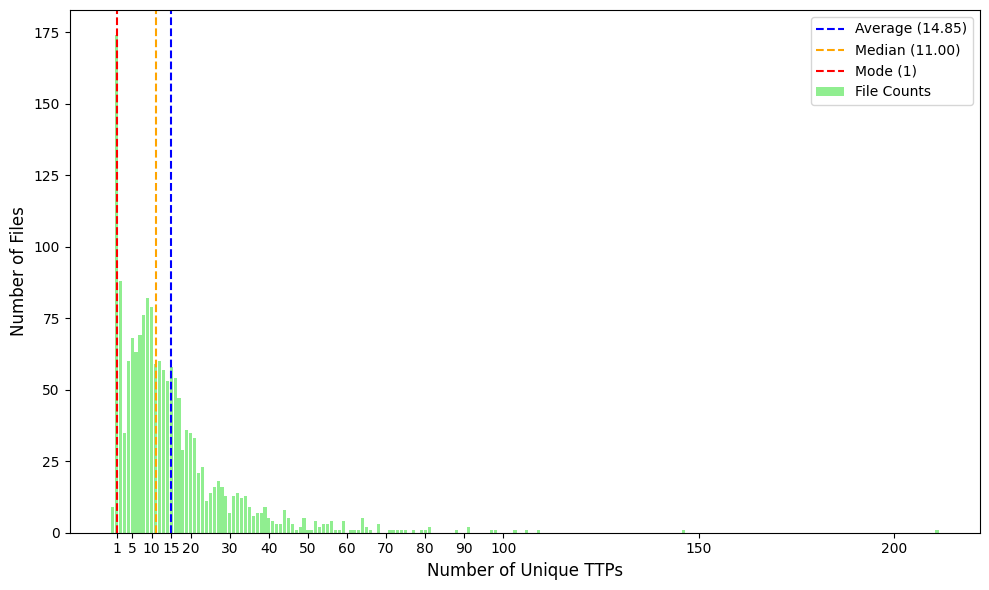

In [16]:
# Display the TTP bucket distribution chart
plot_file_count_by_ttp_buckets(
    ttp_analysis['file_ttp_counts'],  # This is the correct list of TTP counts for each file
    ttp_analysis['average_ttps'], 
    ttp_analysis['median_ttps'], 
    ttp_analysis['mode_ttps']
)

In [17]:
def extract_metadata_from_files(metadata_file_paths, bib_file_path):
    # Dictionary to store the results from both files
    metadata_dict = {}

    # Regex pattern to capture URL and date from the .bib file
    url_pattern = re.compile(r"url\s*=\s*{(.+?)}", re.IGNORECASE)
    date_pattern = re.compile(r"date\s*=\s*{(.+?)}", re.IGNORECASE)

    # Dictionary to map URLs to dates from the .bib file
    bib_url_date_map = {}

    # Read the .bib file and extract URL and date
    with open(bib_file_path, 'r', encoding='utf-8') as bib_file:
        current_url = None
        current_date = None

        for line in bib_file:
            url_match = url_pattern.search(line)
            date_match = date_pattern.search(line)

            if url_match:
                current_url = url_match.group(1).strip()

            if date_match:
                current_date = date_match.group(1).strip()

            if current_url and current_date:
                bib_url_date_map[current_url] = current_date
                current_url, current_date = None, None

    # Loop through the metadata files and extract metadata
    for metadata_file_path in metadata_file_paths:
        with open(metadata_file_path, 'r') as meta_file:
            for line in meta_file:
                try:
                    entry = json.loads(line)
                    download_sha256 = entry.get("download_sha256")
                    url = entry.get("url", "")
                    fqdn = urlparse(url).netloc

                    # Try to match the URL from the metadata with the one from the .bib file
                    matched_date = bib_url_date_map.get(url, None)

                    # Add the extracted values to the dictionary
                    if download_sha256:
                        metadata_dict[download_sha256] = {
                            "fqdn": fqdn,
                            "date": matched_date if matched_date else "No Date"
                        }
                        
                except json.JSONDecodeError:
                    print(f"Skipping invalid JSON entry in file: {metadata_file_path}")
    
    return metadata_dict


In [18]:
malpedia_2022_jsonl = os.path.normpath(os.path.join(config_dir, config["jsonl_files"]["Malpedia_2022"]))
malpedia_2024_jsonl = os.path.normpath(os.path.join(config_dir, config["jsonl_files"]["Malpedia_2024"]))

# Specify the metadata file paths
metadata_file_paths = [malpedia_2022_jsonl, malpedia_2024_jsonl]

# Specify the bib file
malpedia_bib_file = os.path.normpath(os.path.join(config_dir, config["bib_files"]["malpedia_bib_file"]))

# Extract metadata from both files and match with the .bib file
combined_metadata = extract_metadata_from_files(metadata_file_paths, malpedia_bib_file)

# Print the resulting dictionary
#for sha256, data in combined_metadata.items():
#    print(f"SHA256: {sha256}, FQDN: {data['fqdn']}, Date: {data['date']}")

In [10]:
# Set up logging to a file
logging.basicConfig(filename='skipped_dates.log', level=logging.INFO)

def count_reports_per_month(metadata_dict):
    # Dictionary to store the count of reports per month
    monthly_report_count = defaultdict(int)

    # Loop through the metadata dictionary
    for sha256, data in metadata_dict.items():
        # Extract the date from metadata
        date_str = data.get("date", None)

        if date_str:
            try:
                # If the date is just a year (e.g., "2020"), skip it
                if len(date_str) == 4:  # Year only (e.g., "2020")
                    continue
                
                # If the date is a month (e.g., "2020-12"), process it
                elif len(date_str) == 7:  # Year and month (e.g., "2020-12")
                    # Parse the month-year
                    date_obj = datetime.strptime(date_str, "%Y-%m")
                    month_year = date_obj.strftime('%Y-%m')
                    monthly_report_count[month_year] += 1
                
                # If the date is a full date (e.g., "2020-12-31"), process it
                elif len(date_str) == 10:  # Full date (e.g., "2020-12-31")
                    date_obj = datetime.strptime(date_str, "%Y-%m-%d")
                    month_year = date_obj.strftime('%Y-%m')
                    monthly_report_count[month_year] += 1
                
                # Skip invalid date formats
                else:
                    logging.info(f"Skipping file with invalid date format: {date_str}")
            
            except ValueError:
                logging.info(f"Skipping file with invalid date format: {date_str}")
    
    return monthly_report_count

# Get the count of reports per month
monthly_report_count = count_reports_per_month(combined_metadata)


In [19]:
def count_reports_per_month(folder_paths, metadata_dict):
    # Dictionary to store the count of reports per month
    monthly_report_count = defaultdict(int)

    # Loop through each folder path
    for folder_path in folder_paths:
        # Loop through the files in the current folder
        for filename in os.listdir(folder_path):
            # Extract the download_sha256 from the file name (before the first '.')
            if filename.endswith(".download.iocs"):
                download_sha256 = filename.split(".")[0]

                # Check if the download_sha256 exists in the metadata dictionary
                metadata = metadata_dict.get(download_sha256)
                
                if metadata:
                    date = metadata.get('date')

                    # If date exists, try to process it
                    if date:
                        try:
                            # Handle different date formats
                            if len(date) == 7:  # Year-Month format (e.g., "2022-08")
                                date_obj = datetime.strptime(date, '%Y-%m')
                                month_year = date_obj.strftime('%Y-%m')
                                monthly_report_count[month_year] += 1
                            elif len(date) == 10:  # Full date format (e.g., "2022-08-10")
                                date_obj = datetime.strptime(date, '%Y-%m-%d')
                                month_year = date_obj.strftime('%Y-%m')
                                monthly_report_count[month_year] += 1
                        except ValueError:
                            continue  # Skip files with invalid date format
                        
    return monthly_report_count


In [20]:
# Example usage:
folder_paths = [
    malpedia_2022_ttp,
    malpedia_2024_ttp
]

# Assuming metadata_dict is already populated with the relevant data
monthly_report_count_ttp = count_reports_per_month(folder_paths, combined_metadata)

# Print the resulting counts
#for month, count in sorted(monthly_report_count_ttp.items()):
#    print(f"{month}: {count}")

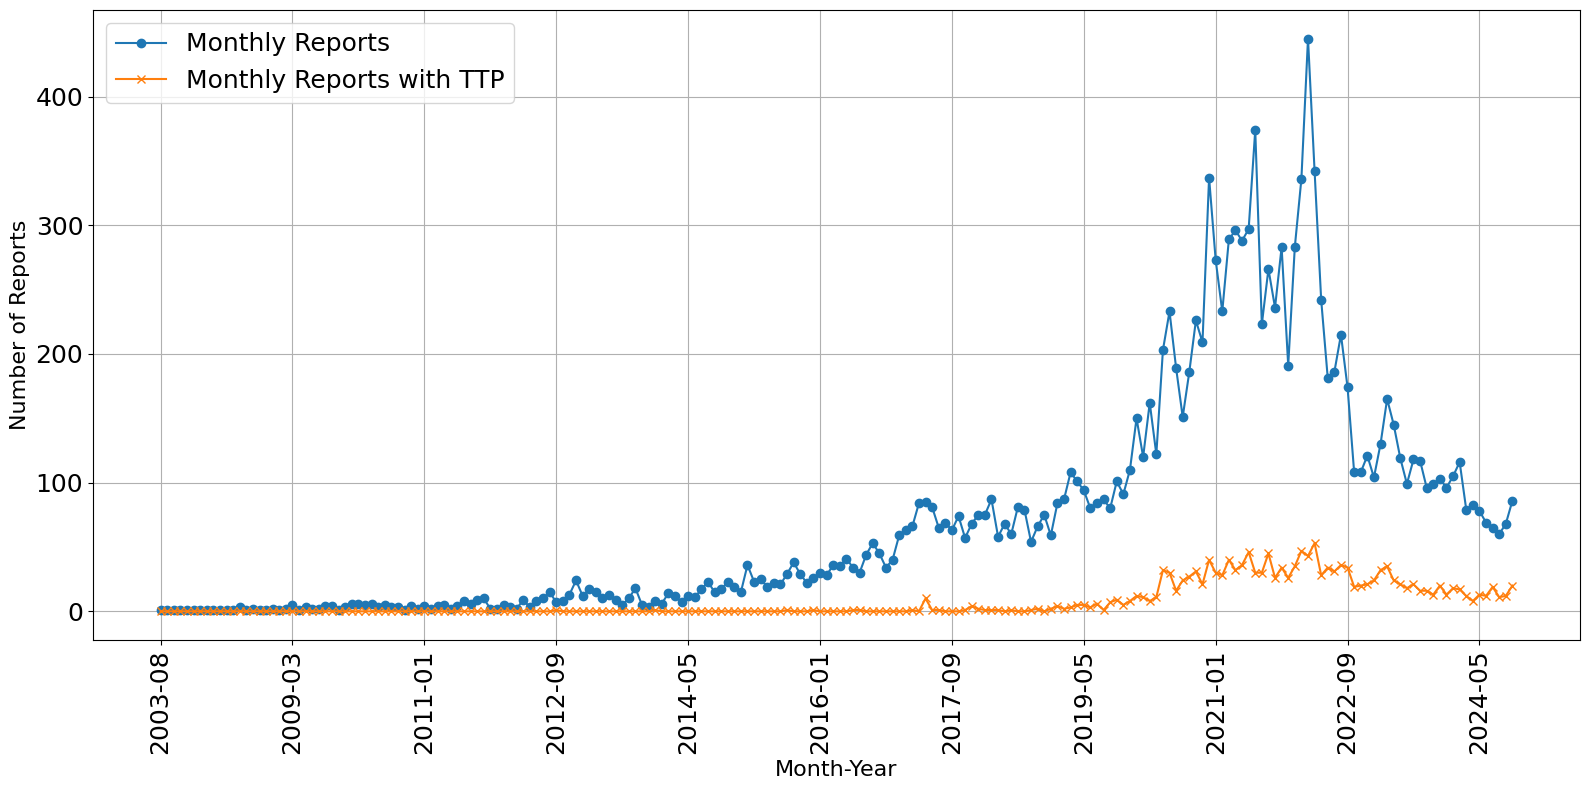

In [21]:
# Combine both datasets
all_months = sorted(set(monthly_report_count.keys()).union(monthly_report_count_ttp.keys()))
report_counts = [monthly_report_count.get(month, 0) for month in all_months]
ttp_counts = [monthly_report_count_ttp.get(month, 0) for month in all_months]

# Exclude the first and last points
all_months = all_months[1:-1]
report_counts = report_counts[1:-1]
ttp_counts = ttp_counts[1:-1]


# Plotting
plt.figure(figsize=(16, 8))
plt.plot(all_months, report_counts, label='Monthly Reports', marker='o')
plt.plot(all_months, ttp_counts, label='Monthly Reports with TTP', marker='x')

# Customize the x-axis
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=15))  # Show at most 12 ticks
plt.xticks(rotation=90, fontsize=18)  # Rotate x-axis labels
plt.yticks(fontsize=18)
plt.xlabel('Month-Year', fontsize=16)
plt.ylabel('Number of Reports', fontsize=16)
#plt.title('Monthly Counts of Reports with TTPs vs Total Reports')
plt.grid(True)
plt.legend(fontsize=18)
plt.tight_layout()

plt.savefig("figures/Malpedia_monthly_report_comparison.pdf", format="pdf")

plt.show()